In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [23]:
import pandas as pd
import numpy as np

import glob
import csv

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random

import os
import shutil
import re
import wget
import requests as req
from io import BytesIO

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Reshape,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

from sklearn.metrics import classification_report, confusion_matrix

# Подготовительный этап
Полагаем, что изначально имеем папки с квадратными изображениями одного размера соответствующих классов (две папки - два класса).  

В противном случае выполним преобразование:  
<br>
`for file_name in os.listdir(<путь до сырых картинок>):
    im = Image.open(<путь до сырых картинок> + file_name)
    square_im = crop_max_square(im)
    scaled_im = square_im.resize(img_size)
    scaled_im.save(
        <путь до преобразованных картинок> + file_name)`
        
`crop_max_square` описано ниже

## Глобальные константы

In [24]:
img_size=(250, 250, 3) # используемый размер изображения
batch_size=25 # размер батча - во всех моделях один и тот же
max_epochs=100 # макс. кол-во эпох
classes=['Ilya','Solovey'] # список классов

main_path='C:/Users/injen/Desktop/PyProjects/ML&DS/Inf_El/LABs/CNN_Ilya_Solovey/' # директория папки проекта
#main_path='/content/gdrive/My Drive/CNN_Ilya_Solovey/' # директория папки проекта
save_dir=[main_path+'model_1/',main_path+'model_2/',main_path+'model_3/'] # адреса сохранения моделей
saved_name=['best_cnn.h5','best_cnn.h5','best_cnn.h5'] # имя соотв. сохр. модели

## Фукнция обрезки изображения
Изображение обрезается до центрального наибольшего квадрата

In [25]:
def crop_max_square(pil_img):
    img_width, img_height = pil_img.size
    min_size = min(img_width, img_height)
    return pil_img.crop(((img_width - min_size) // 2,
                         (img_height - min_size) // 2,
                         (img_width + min_size) // 2,
                         (img_height + min_size) // 2))

## Функции переименования изображений и получения названия их класса
Изображения из исходных папок сохраняются в общую папку с уникальным именем.

In [26]:
def rename_n_move(direc_old,direc_new,keyword):
    folder = os.listdir(direc_old)
    for i, file_name in enumerate(folder): 
        file_oldname = os.path.join(direc_old, file_name)
        point_pos=file_oldname[::-1].find('.')
        im = Image.open(direc_old + file_name)
        im.save(direc_new+keyword+'_'+str(i)+file_oldname[-(point_pos+1):])
            
def get_fname_class(arr_data, path):
    for root, dirs, files in os.walk(path):
        for filename in files:
            key_pos=filename.find('_')
            arr_data.append([filename, filename[:key_pos]])    
    return arr_data

## Функция создания каталога с двумя подкаталогами

In [27]:
def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    os.makedirs(os.path.join(dir_name, classes[0]))
    os.makedirs(os.path.join(dir_name, classes[1]))

## Функция определения класса одного конкретного изображения

In [65]:
def classificaton_img(image,type_img):
    x_test=np.asarray(image, dtype=np.float64)
    x_test=x_test.reshape(1,img_size[0],img_size[1],img_size[2])
    x_test=x_test/255
    prediction=model_used.predict(x_test)
    if prediction[0][0]>prediction[0][1]:
        print('{} ({}, вер. {:.3f})'.format(classes[0],type_img,prediction[0][0]), end='')
    elif prediction[0][0]<prediction[0][1]:
        print('{} ({}, вер. {:.3f})'.format(classes[1],type_img,prediction[0][1]), end='')
    else:
        print('непонятно кто ({})'.format(type_img), end='')   

## Подготовка данных

In [7]:
img_path_Ilya=main_path+'source_images/Ilya_Muromets/'
img_path_Solovey=main_path+'source_images/The_Nightingale_The_Robber/'

img_path_all=main_path+'all_imgs/'
if os.path.exists(img_path_all):
    shutil.rmtree(img_path_all)
os.makedirs(img_path_all)

Переносим все изображения в одну папку, переименовывая их.

In [8]:
rename_n_move(img_path_Ilya,img_path_all, classes[0])
rename_n_move(img_path_Solovey,img_path_all, classes[1])

Теперь все имеющиеся изображения находятся в одной папке и имеют уникальные порядковые номера.  
Разделим их на две: в одной - изображения для обучения и валидации, в другой - для тестирования.  
Для теста выберем 10% изображений от общего числа, а для валидации - 20% от оставшегося количества.

Сформируем списки индексов изображений для соответствующих групп.

In [9]:
test_share=0.1
valid_share=0.2
total=[i for i in range(len(glob.glob(img_path_all+'*'))//len(classes))]

test=random.sample(total, int(test_share*len(total)))

train_n_valid=[item for item in total if item not in test]

valid=random.sample(train_n_valid, int((valid_share*(1-test_share))*len(train_n_valid)))
train=[item for item in train_n_valid if item not in valid]

Создадим папки для соответствующих групп изображений и скопируем изображения по их индексам в имени в соответствующие папки.  
Изображения разных классов копируются в разные подпадпки.

In [10]:
test_path=main_path+'test/'
train_path=main_path+'train/'
valid_path=main_path+'valid/'

In [11]:
create_directory(test_path)
create_directory(train_path)
create_directory(valid_path)

cnt=[0,0,0]
for class_name in classes:
    print(class_name)
    cnt=[0,0,0]
    for file_name in os.listdir(img_path_all):
        im = Image.open(img_path_all + file_name)
        
        if class_name in file_name:
            if int(re.findall('(\d+)', file_name)[0]) in test:
                im.save(test_path+class_name+'/'+file_name)
                cnt[0]+=1
            elif int(re.findall('(\d+)', file_name)[0]) in valid:
                im.save(valid_path+class_name+'/'+file_name)
                cnt[1]+=1
            else:
                im.save(train_path+class_name+'/'+file_name)
                cnt[2]+=1
    else:
        print(cnt)

Ilya
[62, 101, 462]
Solovey
[62, 101, 462]


## Создание наборов данных
Создаём генераторы данных на основе изображений из соответствующих каталогов.  
Keras автоматически определит класс изображения по названию его папки.  
Исходные изображения для обучения и валидации могут быть случайно отражены по горизонтали и вертикали, и повёрнуты на угол до 180 град.

In [12]:
datagen_train_valid = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=180)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train_valid.flow_from_directory(
    train_path,
    target_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    class_mode='categorical')

valid_generator = datagen_train_valid.flow_from_directory(
    valid_path,
    target_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = datagen_test.flow_from_directory(
    test_path,
    target_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 924 images belonging to 2 classes.
Found 202 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


# Создание моделей и их обучение

## Далее представлены три различных модели, самая эффективная - Модель №3.

# Модель №1
Самая ресурсоёмкая модель и не очень точная модель.

In [100]:
model_1 = Sequential([
    Conv2D(filters=32,kernel_size=(3,3), padding='same', strides=1, input_shape = img_size, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=64,kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=128,kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=128,kernel_size=(1,1), padding='same', strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Dropout(0.1),
    Dense(1651, activation='relu', activity_regularizer=regularizers.L2(0.1)),
    Flatten(),
    Dropout(0.25),
    Dense(331, activation='relu', activity_regularizer=regularizers.L2(0.01)),
    Flatten(),
    Dense(2, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

earlyStop = (EarlyStopping(patience = 3, monitor="accuracy", mode="max"))

if not os.path.exists(save_dir[0]):
    os.mkdir(save_dir[0])

checkPoint = ModelCheckpoint(save_dir[0]+saved_name[0], monitor='accuracy', mode='max', verbose=1)

model_1.summary()

model_1.fit(
    train_generator,
    #steps_per_epoch=nb_train_samples // batch_size,
    epochs=max_epochs,
    validation_data=valid_generator,
    #validation_steps=nb_validation_samples // batch_size,
    callbacks=[earlyStop,checkPoint]
)

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_348 (Conv2D)          (None, 250, 250, 32)      896       
_________________________________________________________________
max_pooling2d_348 (MaxPoolin (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_349 (Conv2D)          (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_349 (MaxPoolin (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_350 (Conv2D)          (None, 62, 62, 128)       73856     
_________________________________________________________________
max_pooling2d_350 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_351 (Conv2D)          (None, 31, 31, 128)     

# Модель №2
Наименее ресурсоёмкая модель. Не обесечивает требуюмую точность.

In [121]:
model_2 = Sequential([
    Conv2D(filters=1,kernel_size=(4,4), padding='same', strides=2, input_shape = img_size, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=2,kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=4,kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=2,kernel_size=(1,1), padding='same', strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    
    Dropout(0.25),
    Dense(4, activation='relu'),
    Flatten(),
    Dense(2, activation='softmax')
])

model_2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

earlyStop = (EarlyStopping(patience = 8, monitor="accuracy", mode="max"))

if not os.path.exists(save_dir[1]):
    os.mkdir(save_dir[1])

checkPoint = ModelCheckpoint(save_dir[1]+saved_name[1], monitor='accuracy', mode='max', verbose=1)

model_2.summary()

model_2.fit(
    train_generator,
    #steps_per_epoch=nb_train_samples // batch_size,
    epochs=max_epochs,
    validation_data=valid_generator,
    #validation_steps=nb_validation_samples // batch_size,
    callbacks=[earlyStop,checkPoint]
)

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_432 (Conv2D)          (None, 125, 125, 1)       49        
_________________________________________________________________
max_pooling2d_432 (MaxPoolin (None, 62, 62, 1)         0         
_________________________________________________________________
conv2d_433 (Conv2D)          (None, 62, 62, 2)         20        
_________________________________________________________________
max_pooling2d_433 (MaxPoolin (None, 31, 31, 2)         0         
_________________________________________________________________
conv2d_434 (Conv2D)          (None, 31, 31, 4)         76        
_________________________________________________________________
max_pooling2d_434 (MaxPoolin (None, 15, 15, 4)         0         
_________________________________________________________________
conv2d_435 (Conv2D)          (None, 15, 15, 2)      

# Модель №3
Самая эффективная модель - развитие модели №2 - по сравнению с предыдущими моделями требует наименьшее количество ресурсов, обеспечивая необходимую точность.

In [139]:
model_3 = Sequential([
    Conv2D(filters=1,kernel_size=(4,4), padding='same', strides=2, input_shape = img_size, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=2,kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=4,kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=2,kernel_size=(1,1), padding='same', strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    
    Dropout(0.2),
    Dense(5,activation='relu'),
    Flatten(),
    Dense(2, activation='softmax')
])

model_3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

earlyStop = (EarlyStopping(patience = 6, monitor="accuracy", mode="max"))

if not os.path.exists(save_dir[2]):
    os.mkdir(save_dir[2])

checkPoint = ModelCheckpoint(save_dir[2]+saved_name[2], monitor='accuracy', mode='max', verbose=1)

model_3.summary()

model_3.fit(
    train_generator,
    #steps_per_epoch=nb_train_samples // batch_size,
    epochs=max_epochs,
    validation_data=valid_generator,
    #validation_steps=nb_validation_samples // batch_size,
    callbacks=[earlyStop,checkPoint]
)

Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_484 (Conv2D)          (None, 125, 125, 1)       49        
_________________________________________________________________
max_pooling2d_484 (MaxPoolin (None, 62, 62, 1)         0         
_________________________________________________________________
conv2d_485 (Conv2D)          (None, 62, 62, 2)         20        
_________________________________________________________________
max_pooling2d_485 (MaxPoolin (None, 31, 31, 2)         0         
_________________________________________________________________
conv2d_486 (Conv2D)          (None, 31, 31, 4)         76        
_________________________________________________________________
max_pooling2d_486 (MaxPoolin (None, 15, 15, 4)         0         
_________________________________________________________________
conv2d_487 (Conv2D)          (None, 15, 15, 2)      

# Проверка моделей
Построим матрицу ошибок для каждой сохранённой модели для данных train'а и test'а.

Загружаем модели.

In [29]:
our_model=[]
for i,direc in enumerate(save_dir):
    our_model.append(load_model(direc+saved_name[i]))

### Матрицы ошибок для train'a
Перезададим генератор для train'a - уберём элементы случайности, чтобы добиться однозначности генерации.  
По параметрам такой генеатор идентичен генератору test.

In [141]:
train_pred_generator = datagen_test.flow_from_directory(
    train_path,
    target_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 924 images belonging to 2 classes.


Модель №1:
37/37 [==============================] - 12s 332ms/step - loss: 0.0958 - accuracy: 0.9892
Модель №2:
37/37 [==============================] - 2s 41ms/step - loss: 0.0444 - accuracy: 0.9870
Модель №3:
37/37 [==============================] - 4s 98ms/step - loss: 0.0295 - accuracy: 0.9892


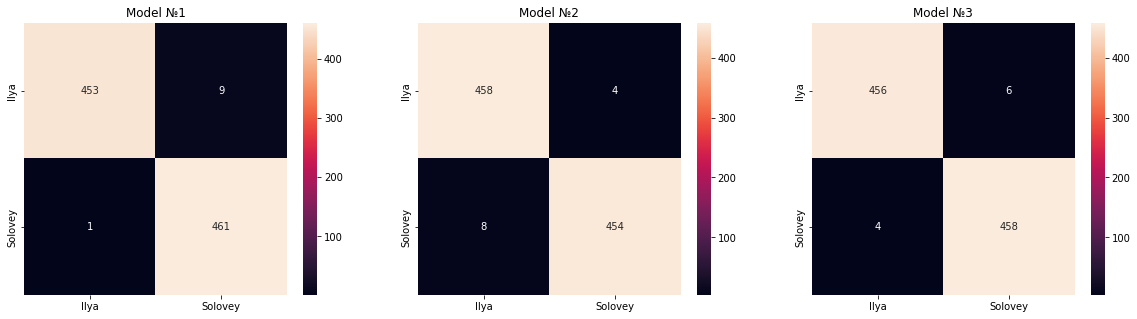

In [142]:
y_pred_train=[]
for i,cnn in enumerate(our_model):
    y_pred_train.append(cnn.predict(train_pred_generator))
    print('Модель №{}:'.format(i+1))
    cnn.evaluate(train_pred_generator)
y_pred_train_classes=np.argmax(y_pred_train, axis=2)

cnfsn_mtrx_train=[]
for pred_classes in y_pred_train_classes:
    cnfsn_mtrx_train.append(confusion_matrix(train_pred_generator.classes, pred_classes))

f,axes=plt.subplots(1,3,figsize=(20,5))
for i,plot in enumerate(cnfsn_mtrx_train):
    sns.heatmap(plot, annot=True, fmt='.0f', ax=axes[i])
    axes[i].set_title('Model №{}'.format(i+1))
    axes[i].set_xticklabels(classes)
    axes[i].set_yticklabels(classes)

### Матрицы ошибок для test'a

Модель №1:
5/5 [==============================] - 2s 335ms/step - loss: 0.0805 - accuracy: 1.0000
Модель №2:
5/5 [==============================] - 0s 38ms/step - loss: 0.0594 - accuracy: 0.9677
Модель №3:
5/5 [==============================] - 0s 40ms/step - loss: 0.0193 - accuracy: 0.9919


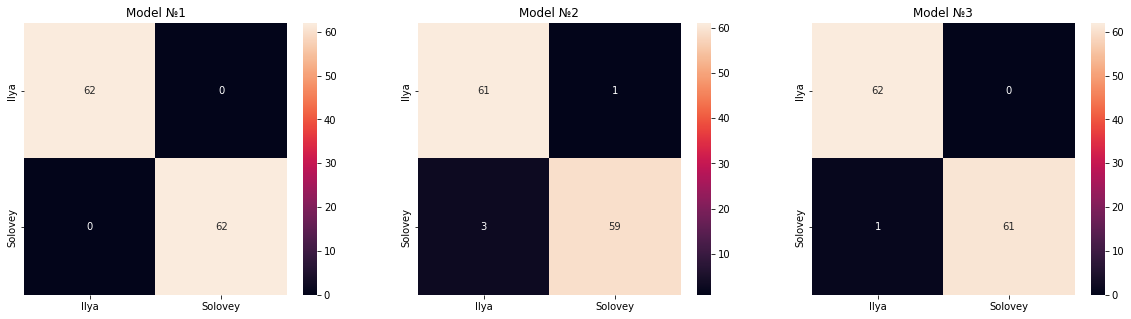

In [143]:
y_pred_test=[]
for i,cnn in enumerate(our_model):
    y_pred_test.append(cnn.predict(test_generator))
    print('Модель №{}:'.format(i+1))
    cnn.evaluate(test_generator)
y_pred_test_classes=np.argmax(y_pred_test, axis=2)

cnfsn_mtrx_test=[]
for pred_classes in y_pred_test_classes:
    cnfsn_mtrx_test.append(confusion_matrix(test_generator.classes, pred_classes))

f,axes=plt.subplots(1,3,figsize=(20,5))
for i,plot in enumerate(cnfsn_mtrx_test):
    sns.heatmap(plot, annot=True, fmt='.0f', ax=axes[i])
    axes[i].set_title('Model №{}'.format(i+1))
    axes[i].set_xticklabels(classes)
    axes[i].set_yticklabels(classes)

## Проверка на конкретных изображениях

Имеем папку с изображениями исходных классов случайных размеров (скачали из интернета).

НН обучалась на квадратных изображениях с нормальными пропорциями, поэтому для корректной классификации тестовых данных исходное изображение следует обрезать до наибольшего центрального квадрата и масштабировать до требуемого размера img_size.

Однако, НН также успешно (но хуже) классифицирует изображения с изменёнными пропорциями (когда прямоугольник сжимают в квадрат).

Следует также учитывать, что, обрезая тестовое изображение до квадрата, можно потерять часть полезных данных.

Поэтому для каждого тестового изображения НН даст два ответа: для его нормального (но обрезанного) вида и для вида с изменёнными пропорциями, причём первому ответу в общем случае следует отдавать предпочтение.

### В папке с сырыми тестовыми изображениями создаются две папки: для квадратных и просто ресайзнутых. Поддерживаются только .jpeg, .jpg и .webp форматы.

In [70]:
mode = 0 # 0 - если проверяется изображение из интернета; 1 - если из директории

# адресс изображения в интернете для скачивания
url= 'https://i.pinimg.com/564x/4d/5f/71/4d5f710e6b31e7fa55052c821a1bb11f.jpg'

# путь до папки с тестовыми уже скачанными сырыми изображениями
test_path=main_path+'real_img/' # НН класиифицирует каждое изображение в этой папке

if mode:
    test_squared_path=(test_path+'squared/')
    test_just_resized_path=(test_path+'just_resized/')

    if not os.path.exists(test_squared_path):
        os.mkdir(test_squared_path)
    if not os.path.exists(test_just_resized_path):
        os.mkdir(test_just_resized_path)

    for file_name in os.listdir(test_path):
        if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.webp'):
            im = Image.open(test_path + file_name)

            im_squared = crop_max_square(im)
            scaled_im = im_squared.resize((img_size[0],img_size[1]))
            scaled_im.save(test_squared_path + file_name)

            just_resized=im.resize((img_size[0],img_size[1]))
            just_resized.save(test_just_resized_path+file_name) 

Выбираем модель и предсказываем класс.

In [71]:
model_used=our_model[2]

if mode:
    for file_name in os.listdir(test_path):
        if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.webp'):
            print('На изображении "{}" -- '.format(file_name), end='')

            img_squared=Image.open(test_squared_path + file_name)
            classificaton_img(img_squared,'норм. проп.')
            print(' или ',end='')

            img_just_resized=Image.open(test_just_resized_path + file_name)
            classificaton_img(img_just_resized,'изм. проп.')
            print()
else:
    response = req.get(url)
    im = Image.open(BytesIO(response.content))
    print('На изображении {} -- '.format('по URL'), end='')
    im_squared = crop_max_square(im)
    scaled_im = im_squared.resize((img_size[0],img_size[1]))
    classificaton_img(scaled_im,'норм. проп.')
    
    print(' или ',end='')
    
    just_resized=im.resize((img_size[0],img_size[1]))
    classificaton_img(just_resized,'изм. проп.')
    

На изображении по URL -- Ilya (норм. проп., вер. 0.853) или Ilya (изм. проп., вер. 0.851)

### Исходные материалы и актуальные модели доступны по ссылке:

https://drive.google.com/drive/folders/17grYsTBmWnJSMvdK7KvpID0zheJYlxlj?usp=sharing